In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

import sympy as sym

In [2]:
# setup of variables
m1,m2,m3,k1,k2,k3,k4,time = sym.symbols('m_1,m_2,m_3,k_1,k_2,k_3,k_4,t') # constants and time
x1 = sym.Function(r'\x_1')(time) # angles
x2 = sym.Function(r'\x_2')(time)
x3 = sym.Function(r'\x_3')(time)
x1d = x1.diff(time) # angular velocites
x2d = x2.diff(time)
x3d = x3.diff(time)
x1dd = x1.diff(time,2) # angular acceleration (we will be solving for these, but it will be useful to have them defined as symbols)
x2dd = x2.diff(time,2)
x3dd = x3.diff(time,2)

# Lagrangian Setup
T = 0.5 * (k1 * x1**2 + k2 * (x1 - x2)**2 + k3 * (x2 - x3)**2 + k4 * x3**2)
V =  0.5 * (m1* x1d **2 + m2 * x2d**2 + m3 * x3d **2)
L = T - V

# Get EOMs from Euler-Lagrange Equation:
left = L.diff(x1)
right = L.diff(x1d).diff(time)
x1dd = sym.solve(sym.Eq(left,right),x1dd)

left1 = L.diff(x2)
right1 = L.diff(x2d).diff(time)
x2dd = sym.solve(sym.Eq(left1,right1),x2dd)

left2 = L.diff(x3)
right2 = L.diff(x3d).diff(time)
x3dd = sym.solve(sym.Eq(left2,right2),x3dd)

In [3]:
print(x1dd,"\n",x2dd,"\n",x3dd)

[(-k_1*\x_1(t) - k_2*\x_1(t) + k_2*\x_2(t))/m_1] 
 [(k_2*\x_1(t) - k_2*\x_2(t) - k_3*\x_2(t) + k_3*\x_3(t))/m_2] 
 [(k_3*\x_2(t) - k_3*\x_3(t) - k_4*\x_3(t))/m_3]


In [4]:
x1dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x1dd,'numpy')
x2dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x2dd,'numpy')
x3dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x3dd,'numpy')

In [5]:
def derivs(t,curr_vals,m1,m2,m3,k1,k2,k3,k4):

    x1,x1d,x2,x2d,x3,x3d = curr_vals

    return x1d, x1dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0], x2d, x2dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0], x3d, x3dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0]

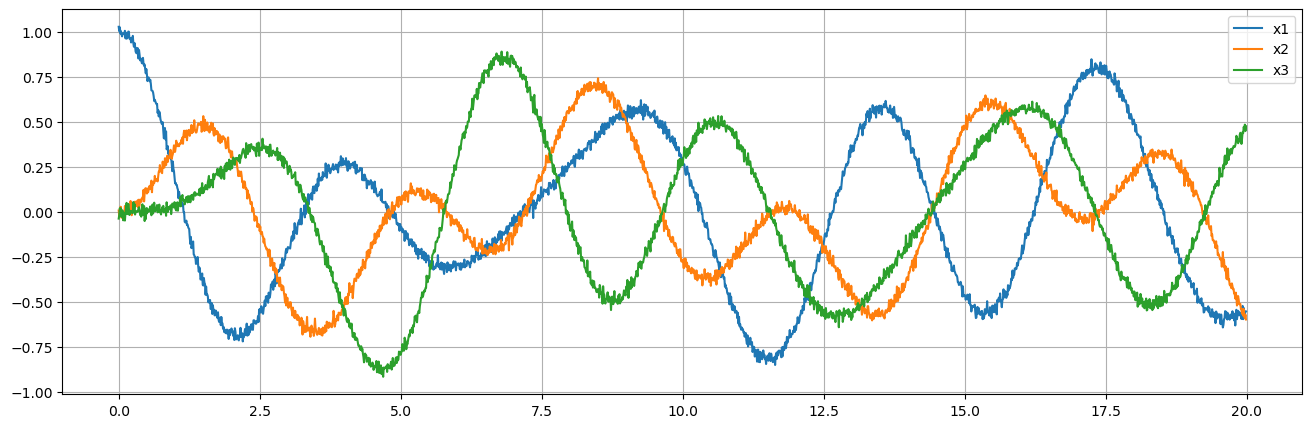

In [70]:
initial = [0,1,0,0,0,0]

tmax = 20
dt = 0.01
t = np.arange(0,tmax,dt)

m1 = 1.
m2 = 1.
m3 = 1.
k1 = 1.
k2 = 1.
k3 = 1.
k4 = 1.
#print(derivs(t,initial,m1,m2,m3,k1,k2,k3,k4))
solved = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4))

noise_sigma = 0.02
y_true = solved.y +  noise_sigma* np.random.randn(6,len(t))
x1,x2,x3 = y_true[1], y_true[3],y_true[5]
plt.figure(figsize=(16,5))
plt.plot(t,x1, label = 'x1')
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.legend()
plt.grid()
plt.show()

In [20]:
sigma = 0.25
def log_likelihood(theta):
    k1,k2,k3,k4 = theta
    sol = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA")
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sol.y)**2)

log_likelihood([k1 + 1,k2,k3,k4])

-1416.825678930586

In [28]:
D = 4
LB = np.full((1, D), 0)  # Lower bounds
UB = np.full((1, D), 100)  # Upper bounds


PLB = np.full((1, D), 0.1)
PUB = np.full((1, D), 10.0)

x0 = 4 * np.ones((1, D))

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "max_fun_evals": 500
}

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0) # I hate this
print(LB < PLB)
print(PLB< PUB)
print(PUB < UB)

LB: [[0 0 0 0]] PLB: [[0.1 0.1 0.1 0.1]] PUB: [[10. 10. 10. 10.]] UB: [[100 100 100 100]] x0: [[4. 4. 4. 4.]]
[[ True  True  True  True]]
[[ True  True  True  True]]
[[ True  True  True  True]]


In [29]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior,options = options) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Casting lower bounds to floating point.
Casting upper bounds to floating point.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


     0         10       -5856.72      2732.34 219807790934465152.00        2        inf     start warm-up
     1         15       -6018.22       576.20      4732.91        2        inf     
     2         20       -4345.50       672.22      3050.16        2   5.87e+04     
     3         25       -4690.60      1039.37     13559.05        2   2.31e+05     
     4         30       -4541.50       688.53      6931.83        2   1.18e+05     trim data
     5         35       -3148.11      1062.05   1483654.90        2   2.47e+07     
     6         40       -4240.29       855.73      4765.08        2   8.59e+04     
     7         45       -4708.21       211.53      2354.62        2   4.15e+04     
     8         50       -4659.66       145.34      1189.62        2   2.05e+04     
     9         55       -4456.19       349.82       564.49        2   1.13e+04     
    10         60       -4578.95        17.10       164.12        2    3.2e+03     
    11         65       -3969.89       792.84

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


    15         85       -3032.76      1013.90       331.29        2   1.26e+04     
    16         90         586.74       687.74      1172.49        3   3.39e+04     
    17         95         998.35       187.79       711.68        4   1.39e+04     
    18        100        1828.84       281.65       744.66        5   1.61e+04     
    19        105        1832.03        11.92       186.15        6   3.15e+03     
    20        110        1966.84        59.48       275.02        7   5.23e+03     
    21        115        2173.77        61.95       492.67        7   9.11e+03     
    22        120        2415.57       161.99       469.92        8   9.18e+03     
    23        125        2652.67        45.87       362.42        8   6.98e+03     
    24        130        2873.42       154.11       390.22        9   7.75e+03     
    25        135        2752.39         1.47        55.20        9   1.33e+03     
    26        140        2754.83         0.35         0.99       10       21

In [46]:
Xs, _ = vp.sample(int(1e6))

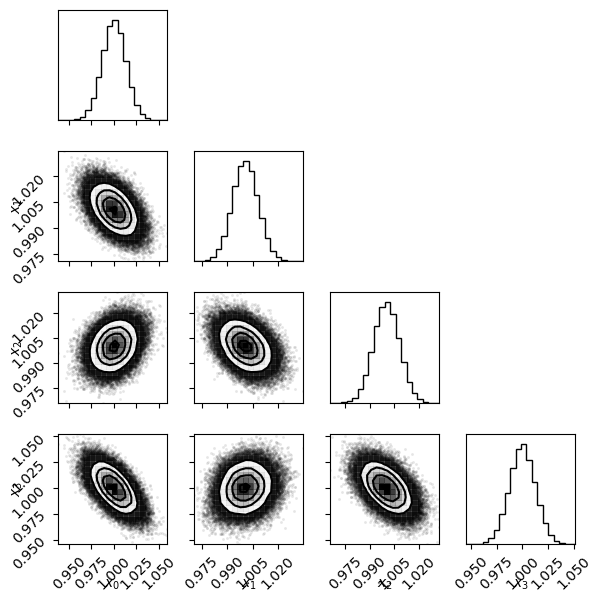

In [30]:
vp.plot();

In [43]:
vp.moments()

array([[1.0000716 , 1.00075295, 1.0001049 , 0.9998901 ]])

In [44]:
log_likelihood(vp.moments()[0])

5570.003732613928

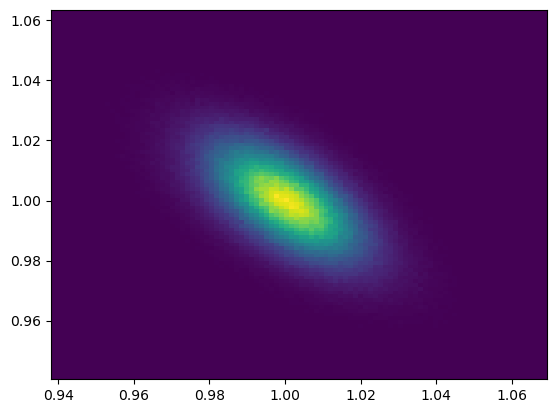

In [47]:
#plt.hist2d(Xs[:,0],Xs[:,1], bins = 100)
plt.hist2d(Xs[:,0],Xs[:,3], bins = 100)
plt.show()

In [48]:
vp.save("4d_oscillators_vp.pkl")

In [60]:
def log_likelihood(theta):
    k1,k2,k3,k4,m1,m2,m3 = theta
    sol = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA")
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sol.y)**2)


D = 7
LB = np.full((1, D), 0)  # Lower bounds
UB = np.full((1, D), 50.0)  # Upper bounds


PLB = np.full((1, D), 0.1)
PUB = np.full((1, D), 10.0)

x0 = 1.5 * np.ones((1, D))

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "max_fun_evals": 1000
}

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0) # I hate this
print(LB < PLB)
print(PLB< PUB)
print(PUB < UB)

LB: [[0 0 0 0 0 0 0]] PLB: [[0.1 0.1 0.1 0.1 0.1 0.1 0.1]] PUB: [[10. 10. 10. 10. 10. 10. 10.]] UB: [[50. 50. 50. 50. 50. 50. 50.]] x0: [[1.5 1.5 1.5 1.5 1.5 1.5 1.5]]
[[ True  True  True  True  True  True  True]]
[[ True  True  True  True  True  True  True]]
[[ True  True  True  True  True  True  True]]


In [61]:
vbmc2 = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior,options = options) # initialize VMBC object

vp2, results2 = vbmc2.optimize() # do optimization (might take a while)

Casting lower bounds to floating point.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


     0         10      -27877.82     30707.72  44008101.54        2        inf     start warm-up
     1         15       20230.90     18045.06    163463.46        2        inf     
     2         20      -13844.49     17330.87     13136.88        2   3.37e+05     
     3         25        3297.64      9185.19    851114.88        2   1.08e+07     
     4         30       14348.07     15242.29     51573.87        2   7.37e+05     
     5         35       11627.28      8864.06     35354.94        2   4.84e+05     
     6         40        5255.43     13157.93     92408.98        2   1.23e+06     
     7         45       14154.29     14392.42     46305.82        2   6.61e+05     
     8         50        9700.66      7298.99     30920.52        2   4.29e+05     
     9         55        7221.12     10922.54    621369.20        2   7.87e+06     
    10         60         997.40      6035.71     17674.56        2   2.64e+05     
    11         65        4392.21      6054.65     18056.56     

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\gpyreg\noise_functions.py:253: RuntimeWarning: overflow encountered in exp
  sn2 = np.exp(2 * hyp[i])


    53        275        5514.56         0.29         7.88       16        110     
    54        280        5515.27         0.05         7.01       15       90.5     
    55        285        5514.84         0.16         4.76       15       61.8     
    56        290        5514.90         0.10         1.52       15       19.6     
    57        295        5514.99         0.07         1.55       15       20.1     
    58        300        5514.89         0.07         1.81       14       23.4     
    59        305        5515.26         0.03         1.79       14       23.8     
    60        310        5515.09         0.03         0.96       15       12.7     
    61        315        5515.24         0.03         0.64       14       8.59     
    62        320        5514.97         0.10         1.74       14       23.1     
    63        325        5515.17         0.03         2.36       13       30.4     
    64        330        5515.05         0.04         0.91       13       11

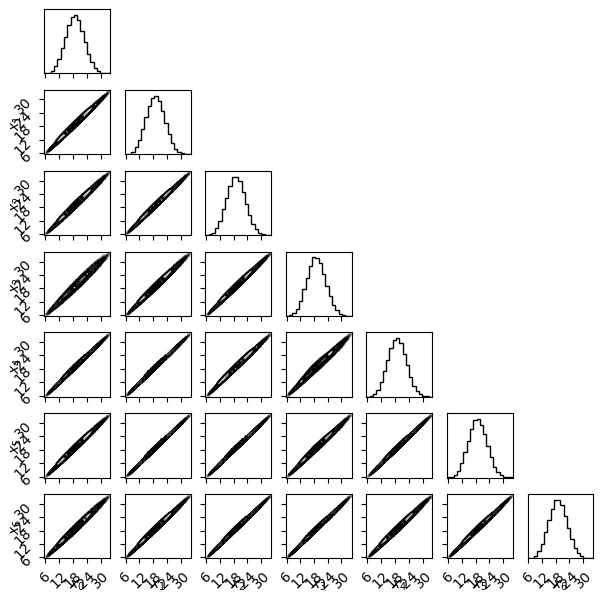

In [62]:
vp2.plot();

In [64]:
vp2.moments()[0]

array([18.8233998 , 18.92512158, 18.98702188, 19.01603549, 18.87195439,
       18.93630333, 18.99230653])

In [65]:
predicted = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = vp2.moments()[0])

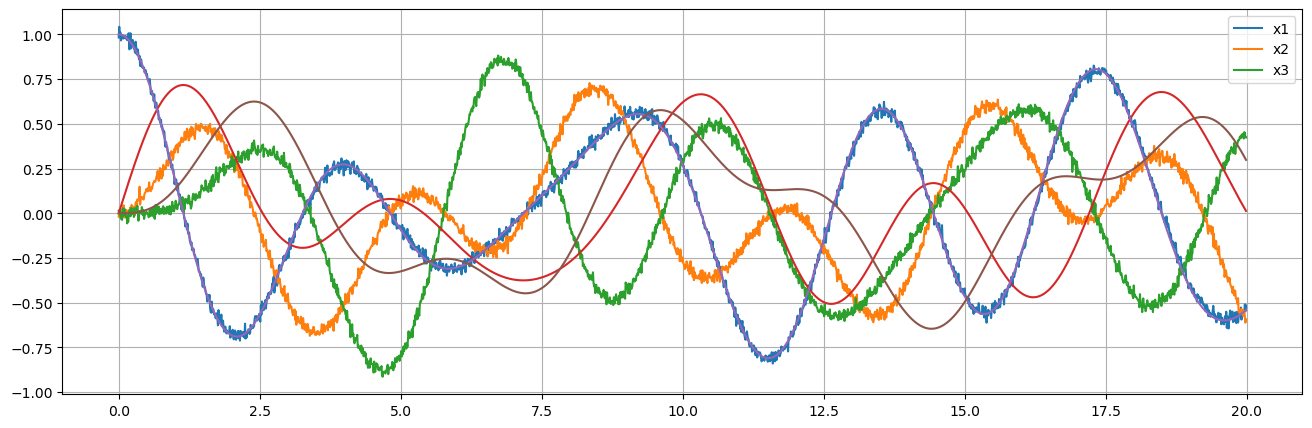

In [68]:
plt.figure(figsize=(16,5))
plt.plot(t,x1, label = 'x1')
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")

plt.plot(t,predicted.y[0])
plt.plot(t,predicted.y[1])
plt.plot(t,predicted.y[2])
plt.legend()
plt.grid()
plt.show()